In [404]:
import pandas as pd
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from IPython.display import display, HTML
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

In [362]:
outcome = "Vote Share"

In [422]:
def read(file):
    results = pd.read_excel("Results_updated.xlsx")
    results = results[results.columns[:5]][:-1]
    results = results.set_index("Twitter ID")
    features = pd.read_excel(file)
    features = features.rename(columns={'Unnamed: 0': 'Twitter ID'})
    features = features.set_index("Twitter ID")
    df = features.merge(results, left_index=True, right_index=True, how='inner')
    return df

In [364]:
def preprocess(df_orig, scale=1):
    df = df_orig.copy(deep=True)
    
    df =  df.fillna(0)

    df_ohe = pd.get_dummies(df[['Party']], drop_first=True)
    df = pd.concat([df_ohe, df], axis=1)
    df.drop(["Party"], axis=1, inplace=True)
    
    if scale:
        scaler = StandardScaler()
        df[['followers', 'avgLikes', 'avgRetweets']] = scaler.fit_transform(df[['followers', 'avgLikes', 'avgRetweets']])
    df_train = df[df['Train/Test']=='Train']
    df_test = df[df['Train/Test']=='Test']
    predictors = list(df_train.columns[:16])
    predictors.remove("Candidate")
    predictors.remove("State")
    return df_train, df_test, df, predictors

In [365]:
def predictWinner(df):
    states = df["State"].unique()
    df["predictedWinner"] = 0
    for state in states:
        df_state = df[df['State'] == state]
        winner = df_state[["predictions"]].idxmax()
        df.at[winner.item(), "predictedWinner"] = 1

# Linear Regression

In [407]:
def linear(df):
    df_train, df_test, df_processed, predictors = preprocess(df)
    reg = linear_model.LinearRegression()
    reg.fit(df_train[predictors], df_train[outcome])
    df_processed["predictions"] = reg.predict(df_processed[predictors])
    predictWinner(df_processed)  
    print("Linear Results!")
    display(df_processed[(df_processed["Elected"] != df_processed["predictedWinner"]) & (df["Train/Test"] == "Train")])
    display(df_processed[(df_processed["Elected"] != df_processed["predictedWinner"]) & (df["Train/Test"] == "Test")])

# Lasso Regression

In [408]:
def lasso(df):
    df_train, df_test, df_processed, predictors = preprocess(df)
    reg = linear_model.Lasso(alpha=0.1)
    reg.fit(df_train[predictors], df_train[outcome])
    df_processed["predictions"] = reg.predict(df_processed[predictors])
    predictWinner(df_processed)
    print("Lasso Results!")
    display(df_processed[(df_processed["Elected"] != df_processed["predictedWinner"]) & (df["Train/Test"] == "Train")])
    display(df_processed[(df_processed["Elected"] != df_processed["predictedWinner"]) & (df["Train/Test"] == "Test")])

# Ridge Regression

In [409]:
def ridge(df):
    df_train, df_test, df_processed, predictors = preprocess(df)
    reg = linear_model.Ridge(alpha=0.5)
    reg.fit(df_train[predictors], df_train[outcome])
    df_processed["predictions"] = reg.predict(df_processed[predictors])
    predictWinner(df_processed)   
    print("Ridge Results!")
    display(df_processed[(df_processed["Elected"] != df_processed["predictedWinner"]) & (df["Train/Test"] == "Train")])
    display(df_processed[(df_processed["Elected"] != df_processed["predictedWinner"]) & (df["Train/Test"] == "Test")])

# CART

In [418]:
def cart(df):
    df_train, df_test, df_processed, predictors = preprocess(df, scale=0)
    clf = tree.DecisionTreeRegressor()
    clf = clf.fit(df_train[predictors], df_train[outcome])
    df_processed["predictions"] = clf.predict(df_processed[predictors])
    predictWinner(df_processed) 
    print("CART Results!")
    display(df_processed[(df_processed["Elected"] != df_processed["predictedWinner"]) & (df["Train/Test"] == "Train")])
    display(df_processed[(df_processed["Elected"] != df_processed["predictedWinner"]) & (df["Train/Test"] == "Test")])
    forest_importances = pd.Series(clf.feature_importances_, index=predictors)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax, title="CART Importance")

# Random Forest

In [416]:
def forest(df):
    df_train, df_test, df_processed, predictors = preprocess(df, scale=0)
    rf = RandomForestRegressor(max_depth=8, min_samples_split=5, random_state=0, max_features=5)
    rf = rf.fit(df_train[predictors], df_train[outcome])
    df_processed["predictions"] = rf.predict(df_processed[predictors])
    predictWinner(df_processed) 
    print("Forest Results!")
    display(df_processed[(df_processed["Elected"] != df_processed["predictedWinner"]) & (df["Train/Test"] == "Train")])
    display(df_processed[(df_processed["Elected"] != df_processed["predictedWinner"]) & (df["Train/Test"] == "Test")])
    forest_importances = pd.Series(rf.feature_importances_, index=predictors)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax, title="Random Forest Importance")

# Bagging

In [412]:
def bagging(df):
    df_train, df_test, df_processed, predictors = preprocess(df, scale=0)
    rf = BaggingRegressor(base_estimator=SVR(), n_estimators=50, random_state=0, max_features=5, max_samples=20)
    rf = rf.fit(df_train[predictors], df_train[outcome])
    df_processed["predictions"] = rf.predict(df_processed[predictors])
    predictWinner(df_processed) 
    print("Bagging Results!")
    display(df_processed[(df_processed["Elected"] != df_processed["predictedWinner"]) & (df["Train/Test"] == "Train")])
    display(df_processed[(df_processed["Elected"] != df_processed["predictedWinner"]) & (df["Train/Test"] == "Test")])

# Boosting - Adaboost

In [413]:
def boosting(df):
    df_train, df_test, df_processed, predictors = preprocess(df, scale=0)
    rf = AdaBoostRegressor(n_estimators=20, random_state=0, learning_rate=2)
    rf = rf.fit(df_train[predictors], df_train[outcome])
    df_processed["predictions"] = rf.predict(df_processed[predictors])
    predictWinner(df_processed) 
    print("Boosting Results!")
    display(df_processed[(df_processed["Elected"] != df_processed["predictedWinner"]) & (df["Train/Test"] == "Train")])
    display(df_processed[(df_processed["Elected"] != df_processed["predictedWinner"]) & (df["Train/Test"] == "Test")])

# TextBlob

Linear Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
RandPaul,0,0,1,Kentucky,Rand Paul,1,5.5396,1.0482,0.9810,2.5415,...,0.9013,0.4593,0.0544,1.8189,Train,1.0000,61.7900,911587.0000,59.9591,0
SenCortezMasto,0,0,0,Nevada,Cathereine Cortez Masto,1,-0.2712,-0.2696,-0.2278,0.3227,...,0.0467,0.1547,0.0259,0.1845,Train,0.0000,48.4300,458696.0000,56.1870,1
TedBuddNC,0,0,1,North Carolina,Ted Budd,0,-0.3615,-0.3445,-0.3902,0.3715,...,0.0231,0.0511,0.0163,0.1068,Train,1.0000,50.7500,1891363.0000,40.4944,0
TheOtherMandela,0,0,0,Wisconsin,Mandela Barnes,0,-0.1574,0.9767,1.9697,1.9541,...,0.4770,0.7056,0.1286,1.1226,Train,0.0000,49.5000,1310416.0000,52.9971,1
DrOz,0,0,1,Pennsylvania,Mehmet Oz,0,5.2995,0.3685,0.6878,3.7917,...,0.2566,0.4650,0.2016,0.9083,Train,0.0000,46.6200,2469945.0000,53.5538,1
GeraldMalloyVT,0,0,1,Vermont,Gerald Malloy,0,-0.3736,-0.3951,-0.4735,0.0430,...,0.0078,0.0086,0.0033,0.0144,Train,0.0000,28.1400,80237.0000,37.5980,1
JohnFetterman,0,0,0,Pennsylvania,John Fetterman,0,0.8546,6.1851,4.9013,4.8259,...,0.4877,1.1594,0.2385,1.3065,Train,1.0000,50.9700,2700885.0000,52.9074,0
KellyForAlaska,0,0,1,Alaska,Kelly Tshibaka,0,-0.3349,-0.2922,-0.2140,0.2179,...,0.1309,0.0965,0.0359,0.1448,Train,1.0000,44.2200,94138.0000,40.6784,0
lisamurkowski,0,0,1,Alaska,Lisa Murkowski,1,0.1147,-0.3786,-0.4585,0.1220,...,0.0077,0.0323,0.0209,0.0921,Train,0.0000,42.8400,91205.0000,57.8332,1


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
AdamLaxalt,0,0,1,Nevada,Adam Laxalt,0,-0.2855,-0.2270,-0.1759,0.7493,...,0.0273,0.0578,0.0550,0.2385,Test,1.0000,48.5100,459494.0000,42.3575,0
Booker4KY,0,0,0,Kentucky,Charles Booker,0,0.2879,4.0453,4.6427,4.1340,...,0.2968,1.6608,0.0435,2.2174,Test,0.0000,38.2100,563676.0000,63.8686,1
CheriBeasleyNC,0,0,0,North Carolina,Cheri Beasley,0,-0.2830,1.0017,1.5394,1.1373,...,0.1582,0.3051,0.1096,0.3134,Test,0.0000,47.1100,1755743.0000,45.3875,1
SenRonJohnson,0,0,1,Wisconsin,Ronald Harold Johnson,1,0.2052,2.0412,3.3380,-5.4054,...,-0.7708,-0.4206,0.0000,-1.4048,Test,1.0000,50.5000,1336870.0000,35.1893,0


Lasso Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
SenCortezMasto,0,0,0,Nevada,Cathereine Cortez Masto,1,-0.2712,-0.2696,-0.2278,0.3227,...,0.0467,0.1547,0.0259,0.1845,Train,0.0000,48.4300,458696.0000,54.8255,1
TedBuddNC,0,0,1,North Carolina,Ted Budd,0,-0.3615,-0.3445,-0.3902,0.3715,...,0.0231,0.0511,0.0163,0.1068,Train,1.0000,50.7500,1891363.0000,39.5673,0
TheOtherMandela,0,0,0,Wisconsin,Mandela Barnes,0,-0.1574,0.9767,1.9697,1.9541,...,0.4770,0.7056,0.1286,1.1226,Train,0.0000,49.5000,1310416.0000,48.2199,1
GeraldMalloyVT,0,0,1,Vermont,Gerald Malloy,0,-0.3736,-0.3951,-0.4735,0.0430,...,0.0078,0.0086,0.0033,0.0144,Train,0.0000,28.1400,80237.0000,38.2287,1
KellyForAlaska,0,0,1,Alaska,Kelly Tshibaka,0,-0.3349,-0.2922,-0.2140,0.2179,...,0.1309,0.0965,0.0359,0.1448,Train,1.0000,44.2200,94138.0000,39.8201,0
lisamurkowski,0,0,1,Alaska,Lisa Murkowski,1,0.1147,-0.3786,-0.4585,0.1220,...,0.0077,0.0323,0.0209,0.0921,Train,0.0000,42.8400,91205.0000,58.2080,1
WelchForVT,0,0,0,Vermont,Peter Welch,0,-0.3679,-0.3706,-0.4601,0.0700,...,0.0090,0.0188,0.0034,0.0117,Train,1.0000,68.5400,195421.0000,32.9141,0


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
AdamLaxalt,0,0,1,Nevada,Adam Laxalt,0,-0.2855,-0.2270,-0.1759,0.7493,...,0.0273,0.0578,0.0550,0.2385,Test,1.0000,48.5100,459494.0000,41.3811,0
CheriBeasleyNC,0,0,0,North Carolina,Cheri Beasley,0,-0.2830,1.0017,1.5394,1.1373,...,0.1582,0.3051,0.1096,0.3134,Test,0.0000,47.1100,1755743.0000,42.8738,1
SenRonJohnson,0,0,1,Wisconsin,Ronald Harold Johnson,1,0.2052,2.0412,3.3380,-5.4054,...,-0.7708,-0.4206,0.0000,-1.4048,Test,1.0000,50.5000,1336870.0000,47.6800,0


Ridge Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
RandPaul,0,0,1,Kentucky,Rand Paul,1,5.5396,1.0482,0.9810,2.5415,...,0.9013,0.4593,0.0544,1.8189,Train,1.0000,61.7900,911587.0000,63.2257,0
SenCortezMasto,0,0,0,Nevada,Cathereine Cortez Masto,1,-0.2712,-0.2696,-0.2278,0.3227,...,0.0467,0.1547,0.0259,0.1845,Train,0.0000,48.4300,458696.0000,54.5085,1
TedBuddNC,0,0,1,North Carolina,Ted Budd,0,-0.3615,-0.3445,-0.3902,0.3715,...,0.0231,0.0511,0.0163,0.1068,Train,1.0000,50.7500,1891363.0000,40.2070,0
TheOtherMandela,0,0,0,Wisconsin,Mandela Barnes,0,-0.1574,0.9767,1.9697,1.9541,...,0.4770,0.7056,0.1286,1.1226,Train,0.0000,49.5000,1310416.0000,50.3626,1
GeraldMalloyVT,0,0,1,Vermont,Gerald Malloy,0,-0.3736,-0.3951,-0.4735,0.0430,...,0.0078,0.0086,0.0033,0.0144,Train,0.0000,28.1400,80237.0000,37.5854,1
KellyForAlaska,0,0,1,Alaska,Kelly Tshibaka,0,-0.3349,-0.2922,-0.2140,0.2179,...,0.1309,0.0965,0.0359,0.1448,Train,1.0000,44.2200,94138.0000,40.0662,0
lisamurkowski,0,0,1,Alaska,Lisa Murkowski,1,0.1147,-0.3786,-0.4585,0.1220,...,0.0077,0.0323,0.0209,0.0921,Train,0.0000,42.8400,91205.0000,57.9062,1
WelchForVT,0,0,0,Vermont,Peter Welch,0,-0.3679,-0.3706,-0.4601,0.0700,...,0.0090,0.0188,0.0034,0.0117,Train,1.0000,68.5400,195421.0000,31.4537,0


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
AdamLaxalt,0,0,1,Nevada,Adam Laxalt,0,-0.2855,-0.2270,-0.1759,0.7493,...,0.0273,0.0578,0.0550,0.2385,Test,1.0000,48.5100,459494.0000,41.9834,0
Booker4KY,0,0,0,Kentucky,Charles Booker,0,0.2879,4.0453,4.6427,4.1340,...,0.2968,1.6608,0.0435,2.2174,Test,0.0000,38.2100,563676.0000,68.5360,1
CheriBeasleyNC,0,0,0,North Carolina,Cheri Beasley,0,-0.2830,1.0017,1.5394,1.1373,...,0.1582,0.3051,0.1096,0.3134,Test,0.0000,47.1100,1755743.0000,44.6826,1
SenRonJohnson,0,0,1,Wisconsin,Ronald Harold Johnson,1,0.2052,2.0412,3.3380,-5.4054,...,-0.7708,-0.4206,0.0000,-1.4048,Test,1.0000,50.5000,1336870.0000,45.5934,0


CART Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
TheOtherMandela,0,0,0,Wisconsin,Mandela Barnes,0,148269,1813.5300,617.9850,1.9541,...,0.4770,0.7056,0.1286,1.1226,Train,0.0000,49.5000,1310416.0000,49.5000,1


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
SenRonJohnson,0,0,1,Wisconsin,Ronald Harold Johnson,1,395932,3208.6818,961.6364,-5.4054,...,-0.7708,-0.4206,0.0000,-1.4048,Test,1.0000,50.5000,1336870.0000,43.1600,0


Forest Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
SenCortezMasto,0,0,0,Nevada,Cathereine Cortez Masto,1,70551,180.2479,66.0579,0.3227,...,0.0467,0.1547,0.0259,0.1845,Train,0.0000,48.4300,458696.0000,51.7735,1
TheOtherMandela,0,0,0,Wisconsin,Mandela Barnes,0,148269,1813.5300,617.9850,1.9541,...,0.4770,0.7056,0.1286,1.1226,Train,0.0000,49.5000,1310416.0000,48.3938,1
KellyForAlaska,0,0,1,Alaska,Kelly Tshibaka,0,27036,150.7143,69.5238,0.2179,...,0.1309,0.0965,0.0359,0.1448,Train,1.0000,44.2200,94138.0000,42.5657,0
lisamurkowski,0,0,1,Alaska,Lisa Murkowski,1,334102,37.4182,8.1182,0.1220,...,0.0077,0.0323,0.0209,0.0921,Train,0.0000,42.8400,91205.0000,49.8477,1
EvanMcMullin,1,0,0,Utah,Evan McMullin,0,514993,1152.4500,310.2600,1.1025,...,0.1441,0.3600,0.0233,0.4882,Train,0.0000,41.6100,377724.0000,45.5541,1


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
AdamLaxalt,0,0,1,Nevada,Adam Laxalt,0,60766,236.1633,79.1122,0.7493,...,0.0273,0.0578,0.0550,0.2385,Test,1.0000,48.5100,459494.0000,50.6473,0
SenRonJohnson,0,0,1,Wisconsin,Ronald Harold Johnson,1,395932,3208.6818,961.6364,-5.4054,...,-0.7708,-0.4206,0.0000,-1.4048,Test,1.0000,50.5000,1336870.0000,26.8106,0
SenMikeLee,0,0,1,Utah,Mike Lee,1,643901,161.4000,40.0000,0.0187,...,0.0014,0.0017,0.0010,0.0070,Test,1.0000,54.6700,496230.0000,14.7932,0


Bagging Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
SenMarkKelly,0,0,0,Arizona,Mark Kelly,1,136417,549.5000,145.6667,0.4816,...,0.1396,0.2026,0.0085,0.2993,Train,1.0000,51.7500,1060031.0000,40.0682,0
TedBuddNC,0,0,1,North Carolina,Ted Budd,0,8892,82.0885,25.2743,0.3715,...,0.0231,0.0511,0.0163,0.1068,Train,1.0000,50.7500,1891363.0000,39.4734,0
GeraldMalloyVT,0,0,1,Vermont,Gerald Malloy,0,565,15.7719,4.3684,0.0430,...,0.0078,0.0086,0.0033,0.0144,Train,0.0000,28.1400,80237.0000,39.3682,1
KellyForAlaska,0,0,1,Alaska,Kelly Tshibaka,0,27036,150.7143,69.5238,0.2179,...,0.1309,0.0965,0.0359,0.1448,Train,1.0000,44.2200,94138.0000,39.5767,0
lisamurkowski,0,0,1,Alaska,Lisa Murkowski,1,334102,37.4182,8.1182,0.1220,...,0.0077,0.0323,0.0209,0.0921,Train,0.0000,42.8400,91205.0000,40.1203,1
WelchForVT,0,0,0,Vermont,Peter Welch,0,4463,47.9437,7.7183,0.0700,...,0.0090,0.0188,0.0034,0.0117,Train,1.0000,68.5400,195421.0000,39.0581,0
EvanMcMullin,1,0,0,Utah,Evan McMullin,0,514993,1152.4500,310.2600,1.1025,...,0.1441,0.3600,0.0233,0.4882,Train,0.0000,41.6100,377724.0000,40.8937,1
HerschelWalker,0,0,1,Georgia,Herschel Walker,0,756537,6363.3684,944.4737,6.6898,...,0.0750,2.2919,0.6888,5.9107,Train,0.0000,48.5200,1906267.0000,41.2276,1
RepValDemings,0,0,0,Florida,Val Demings,0,460893,1411.1300,426.9050,1.2442,...,0.2776,0.6596,0.1659,1.5132,Train,0.0000,41.2600,3198259.0000,41.0055,1


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
bgmasters,0,0,1,Arizona,Blake Masters,0,175270,1099.6527,273.1976,0.8497,...,0.0347,0.2235,0.0933,0.2787,Test,0.0000,46.1300,944958.0000,40.5930,1
CheriBeasleyNC,0,0,0,North Carolina,Cheri Beasley,0,62507,1846.3750,509.9010,1.1373,...,0.1582,0.3051,0.1096,0.3134,Test,0.0000,47.1100,1755743.0000,40.2784,1
SenatorWarnock,0,0,0,Georgia,Raphael Warnock,1,169134,496.4121,132.9636,0.1679,...,0.0539,0.0486,0.0127,0.1128,Test,1.0000,49.4200,1941515.0000,40.0061,0
SenMikeLee,0,0,1,Utah,Mike Lee,1,643901,161.4000,40.0000,0.0187,...,0.0014,0.0017,0.0010,0.0070,Test,1.0000,54.6700,496230.0000,40.6189,0


Boosting Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
MarkwayneMullin,0,0,1,Oklahoma,Markwayne Mullin,0,8774,15.3333,4.9259,0.2146,...,0.0241,0.0196,0.0073,0.0922,Train,0.0000,61.7700,710004.0000,59.6383,1
SenatorLankford,0,0,1,Oklahoma,James Lankford,1,119622,36.9189,8.9189,0.4271,...,0.0427,0.0364,0.0312,0.1800,Train,1.0000,64.3000,739298.0000,59.6383,0
SenCortezMasto,0,0,0,Nevada,Cathereine Cortez Masto,1,70551,180.2479,66.0579,0.3227,...,0.0467,0.1547,0.0259,0.1845,Train,0.0000,48.4300,458696.0000,55.7929,1
TheOtherMandela,0,0,0,Wisconsin,Mandela Barnes,0,148269,1813.5300,617.9850,1.9541,...,0.4770,0.7056,0.1286,1.1226,Train,0.0000,49.5000,1310416.0000,48.7760,1
DrOz,0,0,1,Pennsylvania,Mehmet Oz,0,3875217,1016.5000,296.0300,3.7917,...,0.2566,0.4650,0.2016,0.9083,Train,0.0000,46.6200,2469945.0000,48.7760,1
JohnFetterman,0,0,0,Pennsylvania,John Fetterman,0,839420,8639.3150,1354.2700,4.8259,...,0.4877,1.1594,0.2385,1.3065,Train,1.0000,50.9700,2700885.0000,48.7760,0
KellyForAlaska,0,0,1,Alaska,Kelly Tshibaka,0,27036,150.7143,69.5238,0.2179,...,0.1309,0.0965,0.0359,0.1448,Train,1.0000,44.2200,94138.0000,43.1600,0
lisamurkowski,0,0,1,Alaska,Lisa Murkowski,1,334102,37.4182,8.1182,0.1220,...,0.0077,0.0323,0.0209,0.0921,Train,0.0000,42.8400,91205.0000,43.4929,1
EvanMcMullin,1,0,0,Utah,Evan McMullin,0,514993,1152.4500,310.2600,1.1025,...,0.1441,0.3600,0.0233,0.4882,Train,0.0000,41.6100,377724.0000,48.7760,1


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
AdamLaxalt,0,0,1,Nevada,Adam Laxalt,0,60766,236.1633,79.1122,0.7493,...,0.0273,0.0578,0.0550,0.2385,Test,1.0000,48.5100,459494.0000,54.3275,0
SenRonJohnson,0,0,1,Wisconsin,Ronald Harold Johnson,1,395932,3208.6818,961.6364,-5.4054,...,-0.7708,-0.4206,0.0000,-1.4048,Test,1.0000,50.5000,1336870.0000,36.6400,0
JDVance1,0,0,1,Ohio,J.D Vance,0,272613,845.6667,203.4943,5.3328,...,0.4293,1.0905,0.2612,2.4572,Test,1.0000,53.2800,2147898.0000,48.7760,0
SenMikeLee,0,0,1,Utah,Mike Lee,1,643901,161.4000,40.0000,0.0187,...,0.0014,0.0017,0.0010,0.0070,Test,1.0000,54.6700,496230.0000,4.6700,0


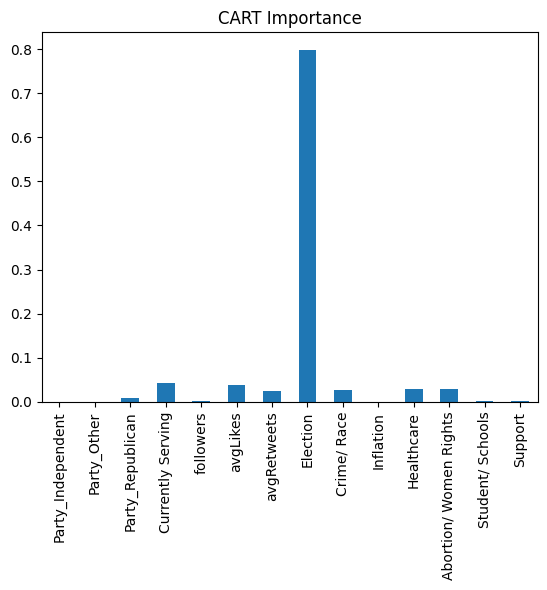

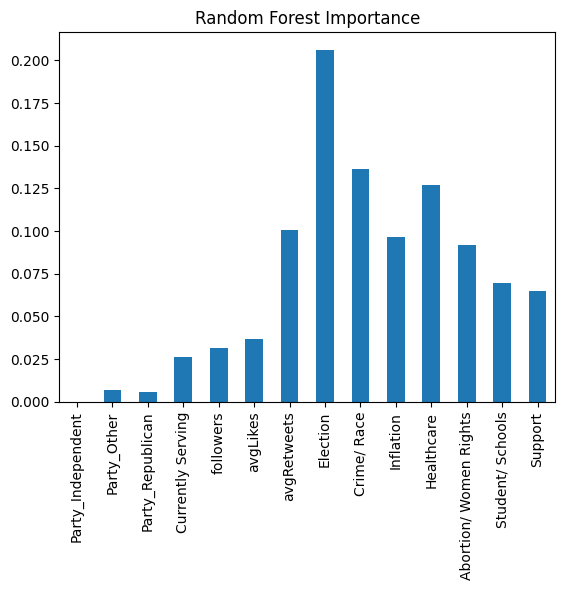

In [419]:
df = read("Features_Blob.xlsx")
linear(df)
lasso(df)
ridge(df)
cart(df)
forest(df)
bagging(df)
boosting(df)

# Flair

Linear Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
RandPaul,0,0,1,Kentucky,Rand Paul,1,5.5396,1.0482,0.9810,-50.2111,...,-17.8073,-9.0743,-1.0744,-35.9345,Train,1.0000,61.7900,911587.0000,60.1025,0
SenCortezMasto,0,0,0,Nevada,Cathereine Cortez Masto,1,-0.2712,-0.2696,-0.2278,-1.3454,...,-0.1947,-0.6450,-0.1080,-0.7689,Train,0.0000,48.4300,458696.0000,54.3215,1
TedBuddNC,0,0,1,North Carolina,Ted Budd,0,-0.3615,-0.3445,-0.3902,-2.7620,...,-0.1717,-0.3797,-0.1212,-0.7941,Train,1.0000,50.7500,1891363.0000,42.4340,0
GeraldMalloyVT,0,0,1,Vermont,Gerald Malloy,0,-0.3736,-0.3951,-0.4735,-0.0204,...,-0.0037,-0.0041,-0.0016,-0.0068,Train,0.0000,28.1400,80237.0000,38.3015,1
KellyForAlaska,0,0,1,Alaska,Kelly Tshibaka,0,-0.3349,-0.2922,-0.2140,-0.9792,...,-0.5884,-0.4338,-0.1612,-0.6506,Train,1.0000,44.2200,94138.0000,41.5688,0
lisamurkowski,0,0,1,Alaska,Lisa Murkowski,1,0.1147,-0.3786,-0.4585,-0.4878,...,-0.0307,-0.1293,-0.0836,-0.3685,Train,0.0000,42.8400,91205.0000,60.0583,1
SmileyForWA,0,0,1,Washington,Tiffany Smiley,0,-0.3448,-0.1075,-0.0947,-4.4003,...,-1.1665,-0.7944,-0.2476,-2.8735,Train,0.0000,43.2600,1083026.0000,43.9864,1
WelchForVT,0,0,0,Vermont,Peter Welch,0,-0.3679,-0.3706,-0.4601,-1.0821,...,-0.1394,-0.2915,-0.0530,-0.1811,Train,1.0000,68.5400,195421.0000,31.9087,0
RepTimRyan,0,0,0,Ohio,Tim Ryan,0,-0.1506,-0.1791,-0.2543,-3.2858,...,-0.5640,-0.4650,-0.1582,-0.9743,Train,0.0000,46.7200,1883223.0000,31.5957,1


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
AdamLaxalt,0,0,1,Nevada,Adam Laxalt,0,-0.2855,-0.2270,-0.1759,-3.5238,...,-0.1286,-0.2719,-0.2587,-1.1216,Test,1.0000,48.5100,459494.0000,44.0684,0
Booker4KY,0,0,0,Kentucky,Charles Booker,0,0.2879,4.0453,4.6427,-14.2801,...,-1.0252,-5.7369,-0.1502,-7.6595,Test,0.0000,38.2100,563676.0000,66.2420,1
CheriBeasleyNC,0,0,0,North Carolina,Cheri Beasley,0,-0.2830,1.0017,1.5394,-0.3626,...,-0.0504,-0.0973,-0.0350,-0.0999,Test,0.0000,47.1100,1755743.0000,51.6131,1
PattyMurray,0,0,0,Washington,Patty Murray,1,0.3473,0.0117,0.0334,-14.7869,...,-1.9147,-16.8020,-1.3346,-11.9744,Test,1.0000,56.7400,1420767.0000,35.7101,0
JDVance1,0,0,1,Ohio,J.D Vance,0,0.0247,0.2381,0.3194,-30.7233,...,-2.4730,-6.2825,-1.5050,-14.1562,Test,1.0000,53.2800,2147898.0000,28.1810,0


Lasso Results!


C:\Users\Arushi Jain\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.187e+03, tolerance: 3.651e+00
  model = cd_fast.enet_coordinate_descent(


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
RandPaul,0,0,1,Kentucky,Rand Paul,1,5.5396,1.0482,0.9810,-50.2111,...,-17.8073,-9.0743,-1.0744,-35.9345,Train,1.0000,61.7900,911587.0000,61.8445,0
SenCortezMasto,0,0,0,Nevada,Cathereine Cortez Masto,1,-0.2712,-0.2696,-0.2278,-1.3454,...,-0.1947,-0.6450,-0.1080,-0.7689,Train,0.0000,48.4300,458696.0000,53.9278,1
TedBuddNC,0,0,1,North Carolina,Ted Budd,0,-0.3615,-0.3445,-0.3902,-2.7620,...,-0.1717,-0.3797,-0.1212,-0.7941,Train,1.0000,50.7500,1891363.0000,42.5303,0
TheOtherMandela,0,0,0,Wisconsin,Mandela Barnes,0,-0.1574,0.9767,1.9697,-10.5211,...,-2.5685,-3.7990,-0.6923,-6.0446,Train,0.0000,49.5000,1310416.0000,45.9506,1
GeraldMalloyVT,0,0,1,Vermont,Gerald Malloy,0,-0.3736,-0.3951,-0.4735,-0.0204,...,-0.0037,-0.0041,-0.0016,-0.0068,Train,0.0000,28.1400,80237.0000,38.5148,1
KellyForAlaska,0,0,1,Alaska,Kelly Tshibaka,0,-0.3349,-0.2922,-0.2140,-0.9792,...,-0.5884,-0.4338,-0.1612,-0.6506,Train,1.0000,44.2200,94138.0000,40.7332,0
lisamurkowski,0,0,1,Alaska,Lisa Murkowski,1,0.1147,-0.3786,-0.4585,-0.4878,...,-0.0307,-0.1293,-0.0836,-0.3685,Train,0.0000,42.8400,91205.0000,59.4165,1
SmileyForWA,0,0,1,Washington,Tiffany Smiley,0,-0.3448,-0.1075,-0.0947,-4.4003,...,-1.1665,-0.7944,-0.2476,-2.8735,Train,0.0000,43.2600,1083026.0000,43.3587,1
WelchForVT,0,0,0,Vermont,Peter Welch,0,-0.3679,-0.3706,-0.4601,-1.0821,...,-0.1394,-0.2915,-0.0530,-0.1811,Train,1.0000,68.5400,195421.0000,33.0408,0


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
AdamLaxalt,0,0,1,Nevada,Adam Laxalt,0,-0.2855,-0.2270,-0.1759,-3.5238,...,-0.1286,-0.2719,-0.2587,-1.1216,Test,1.0000,48.5100,459494.0000,43.0224,0
Booker4KY,0,0,0,Kentucky,Charles Booker,0,0.2879,4.0453,4.6427,-14.2801,...,-1.0252,-5.7369,-0.1502,-7.6595,Test,0.0000,38.2100,563676.0000,67.4517,1
CheriBeasleyNC,0,0,0,North Carolina,Cheri Beasley,0,-0.2830,1.0017,1.5394,-0.3626,...,-0.0504,-0.0973,-0.0350,-0.0999,Test,0.0000,47.1100,1755743.0000,47.9919,1
SenRonJohnson,0,0,1,Wisconsin,Ronald Harold Johnson,1,0.2052,2.0412,3.3380,-83.1991,...,-11.8645,-6.4735,0.0000,-21.6219,Test,1.0000,50.5000,1336870.0000,42.2282,0
PattyMurray,0,0,0,Washington,Patty Murray,1,0.3473,0.0117,0.0334,-14.7869,...,-1.9147,-16.8020,-1.3346,-11.9744,Test,1.0000,56.7400,1420767.0000,43.3476,0
JDVance1,0,0,1,Ohio,J.D Vance,0,0.0247,0.2381,0.3194,-30.7233,...,-2.4730,-6.2825,-1.5050,-14.1562,Test,1.0000,53.2800,2147898.0000,32.1122,0


Ridge Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
RandPaul,0,0,1,Kentucky,Rand Paul,1,5.5396,1.0482,0.9810,-50.2111,...,-17.8073,-9.0743,-1.0744,-35.9345,Train,1.0000,61.7900,911587.0000,61.0511,0
SenCortezMasto,0,0,0,Nevada,Cathereine Cortez Masto,1,-0.2712,-0.2696,-0.2278,-1.3454,...,-0.1947,-0.6450,-0.1080,-0.7689,Train,0.0000,48.4300,458696.0000,53.0075,1
TedBuddNC,0,0,1,North Carolina,Ted Budd,0,-0.3615,-0.3445,-0.3902,-2.7620,...,-0.1717,-0.3797,-0.1212,-0.7941,Train,1.0000,50.7500,1891363.0000,42.8469,0
TheOtherMandela,0,0,0,Wisconsin,Mandela Barnes,0,-0.1574,0.9767,1.9697,-10.5211,...,-2.5685,-3.7990,-0.6923,-6.0446,Train,0.0000,49.5000,1310416.0000,47.5579,1
GeraldMalloyVT,0,0,1,Vermont,Gerald Malloy,0,-0.3736,-0.3951,-0.4735,-0.0204,...,-0.0037,-0.0041,-0.0016,-0.0068,Train,0.0000,28.1400,80237.0000,38.2719,1
KellyForAlaska,0,0,1,Alaska,Kelly Tshibaka,0,-0.3349,-0.2922,-0.2140,-0.9792,...,-0.5884,-0.4338,-0.1612,-0.6506,Train,1.0000,44.2200,94138.0000,41.0520,0
lisamurkowski,0,0,1,Alaska,Lisa Murkowski,1,0.1147,-0.3786,-0.4585,-0.4878,...,-0.0307,-0.1293,-0.0836,-0.3685,Train,0.0000,42.8400,91205.0000,59.7192,1
SmileyForWA,0,0,1,Washington,Tiffany Smiley,0,-0.3448,-0.1075,-0.0947,-4.4003,...,-1.1665,-0.7944,-0.2476,-2.8735,Train,0.0000,43.2600,1083026.0000,43.7755,1
WelchForVT,0,0,0,Vermont,Peter Welch,0,-0.3679,-0.3706,-0.4601,-1.0821,...,-0.1394,-0.2915,-0.0530,-0.1811,Train,1.0000,68.5400,195421.0000,31.5543,0


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
AdamLaxalt,0,0,1,Nevada,Adam Laxalt,0,-0.2855,-0.2270,-0.1759,-3.5238,...,-0.1286,-0.2719,-0.2587,-1.1216,Test,1.0000,48.5100,459494.0000,43.6459,0
Booker4KY,0,0,0,Kentucky,Charles Booker,0,0.2879,4.0453,4.6427,-14.2801,...,-1.0252,-5.7369,-0.1502,-7.6595,Test,0.0000,38.2100,563676.0000,69.8501,1
CheriBeasleyNC,0,0,0,North Carolina,Cheri Beasley,0,-0.2830,1.0017,1.5394,-0.3626,...,-0.0504,-0.0973,-0.0350,-0.0999,Test,0.0000,47.1100,1755743.0000,49.4656,1
SenRonJohnson,0,0,1,Wisconsin,Ronald Harold Johnson,1,0.2052,2.0412,3.3380,-83.1991,...,-11.8645,-6.4735,0.0000,-21.6219,Test,1.0000,50.5000,1336870.0000,39.9889,0
PattyMurray,0,0,0,Washington,Patty Murray,1,0.3473,0.0117,0.0334,-14.7869,...,-1.9147,-16.8020,-1.3346,-11.9744,Test,1.0000,56.7400,1420767.0000,40.8059,0
JDVance1,0,0,1,Ohio,J.D Vance,0,0.0247,0.2381,0.3194,-30.7233,...,-2.4730,-6.2825,-1.5050,-14.1562,Test,1.0000,53.2800,2147898.0000,29.4424,0


CART Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
SenCortezMasto,0,0,0,Nevada,Cathereine Cortez Masto,1,70551,180.2479,66.0579,-1.3454,...,-0.1947,-0.6450,-0.1080,-0.7689,Train,0.0000,48.4300,458696.0000,48.4300,1
SenMarkKelly,0,0,0,Arizona,Mark Kelly,1,136417,549.5000,145.6667,-8.6057,...,-2.4939,-3.6195,-0.1518,-5.3484,Train,1.0000,51.7500,1060031.0000,51.7500,0


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
AdamLaxalt,0,0,1,Nevada,Adam Laxalt,0,60766,236.1633,79.1122,-3.5238,...,-0.1286,-0.2719,-0.2587,-1.1216,Test,1.0000,48.5100,459494.0000,35.2000,0
bgmasters,0,0,1,Arizona,Blake Masters,0,175270,1099.6527,273.1976,-19.3205,...,-0.7901,-5.0817,-2.1218,-6.3381,Test,0.0000,46.1300,944958.0000,55.4700,1


Forest Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
SenCortezMasto,0,0,0,Nevada,Cathereine Cortez Masto,1,70551,180.2479,66.0579,-1.3454,...,-0.1947,-0.6450,-0.1080,-0.7689,Train,0.0000,48.4300,458696.0000,52.0792,1
DrOz,0,0,1,Pennsylvania,Mehmet Oz,0,3875217,1016.5000,296.0300,-128.7260,...,-8.7120,-15.7853,-6.8444,-30.8362,Train,0.0000,46.6200,2469945.0000,49.8513,1
JohnFetterman,0,0,0,Pennsylvania,John Fetterman,0,839420,8639.3150,1354.2700,-74.6469,...,-7.5439,-17.9332,-3.6890,-20.2096,Train,1.0000,50.9700,2700885.0000,49.4600,0
KellyForAlaska,0,0,1,Alaska,Kelly Tshibaka,0,27036,150.7143,69.5238,-0.9792,...,-0.5884,-0.4338,-0.1612,-0.6506,Train,1.0000,44.2200,94138.0000,44.9715,0
lisamurkowski,0,0,1,Alaska,Lisa Murkowski,1,334102,37.4182,8.1182,-0.4878,...,-0.0307,-0.1293,-0.0836,-0.3685,Train,0.0000,42.8400,91205.0000,46.8896,1


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
AdamLaxalt,0,0,1,Nevada,Adam Laxalt,0,60766,236.1633,79.1122,-3.5238,...,-0.1286,-0.2719,-0.2587,-1.1216,Test,1.0000,48.5100,459494.0000,49.3236,0


Bagging Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
BrianBengs,0,0,0,South Dakota,Brian Bengs,0,44577,516.9259,206.1204,-1.1058,...,-0.4639,-0.2974,-0.1403,-0.2820,Train,0.0000,26.1500,90996.0000,39.8695,1
SenatorLankford,0,0,1,Oklahoma,James Lankford,1,119622,36.9189,8.9189,-8.3454,...,-0.8338,-0.7115,-0.6097,-3.5168,Train,1.0000,64.3000,739298.0000,39.4527,0
SenJohnThune,0,0,1,South Dakota,John Thune,1,134203,51.4792,8.6667,-3.6937,...,-0.3518,-0.4718,-0.4717,-1.3767,Train,1.0000,69.6300,242282.0000,39.4237,0
SenMarkKelly,0,0,0,Arizona,Mark Kelly,1,136417,549.5000,145.6667,-8.6057,...,-2.4939,-3.6195,-0.1518,-5.3484,Train,1.0000,51.7500,1060031.0000,39.9755,0
TedBuddNC,0,0,1,North Carolina,Ted Budd,0,8892,82.0885,25.2743,-2.7620,...,-0.1717,-0.3797,-0.1212,-0.7941,Train,1.0000,50.7500,1891363.0000,39.3170,0
KellyForAlaska,0,0,1,Alaska,Kelly Tshibaka,0,27036,150.7143,69.5238,-0.9792,...,-0.5884,-0.4338,-0.1612,-0.6506,Train,1.0000,44.2200,94138.0000,39.4137,0
lisamurkowski,0,0,1,Alaska,Lisa Murkowski,1,334102,37.4182,8.1182,-0.4878,...,-0.0307,-0.1293,-0.0836,-0.3685,Train,0.0000,42.8400,91205.0000,39.6923,1
Eric_Schmitt,0,0,1,Missouri,Eric Schmitt,0,57495,318.6667,75.4298,-12.6297,...,-2.1550,-2.8408,-1.7296,-5.9395,Train,1.0000,55.4700,1143636.0000,39.6786,0
EvanMcMullin,1,0,0,Utah,Evan McMullin,0,514993,1152.4500,310.2600,-5.0899,...,-0.6654,-1.6621,-0.1076,-2.2538,Train,0.0000,41.6100,377724.0000,40.9340,1


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
bgmasters,0,0,1,Arizona,Blake Masters,0,175270,1099.6527,273.1976,-19.3205,...,-0.7901,-5.0817,-2.1218,-6.3381,Test,0.0000,46.1300,944958.0000,40.5711,1
CheriBeasleyNC,0,0,0,North Carolina,Cheri Beasley,0,62507,1846.3750,509.9010,-0.3626,...,-0.0504,-0.0973,-0.0350,-0.0999,Test,0.0000,47.1100,1755743.0000,40.2534,1
madisonhornok,0,0,0,Oklahoma,Madison Horn,0,20052,434.6397,132.1103,-1.4438,...,-0.1294,-0.3498,-0.1247,-0.4442,Test,0.0000,32.1000,368979.0000,39.6454,1
SenatorWarnock,0,0,0,Georgia,Raphael Warnock,1,169134,496.4121,132.9636,-1.8550,...,-0.5951,-0.5369,-0.1406,-1.2458,Test,1.0000,49.4200,1941515.0000,39.8725,0
buschvalentine,0,0,0,Missouri,Trudy Busch Valentine,0,17832,569.5682,210.0341,-1.3130,...,-0.1876,-0.7154,-0.1856,-0.6122,Test,0.0000,42.1400,868875.0000,39.8741,1
SenMikeLee,0,0,1,Utah,Mike Lee,1,643901,161.4000,40.0000,-22.6248,...,-1.6684,-2.0143,-1.1637,-8.4639,Test,1.0000,54.6700,496230.0000,40.3874,0


Boosting Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
MarkwayneMullin,0,0,1,Oklahoma,Markwayne Mullin,0,8774,15.3333,4.9259,-2.0674,...,-0.2319,-0.1889,-0.0699,-0.8885,Train,0.0000,61.7700,710004.0000,57.4453,1
SenatorLankford,0,0,1,Oklahoma,James Lankford,1,119622,36.9189,8.9189,-8.3454,...,-0.8338,-0.7115,-0.6097,-3.5168,Train,1.0000,64.3000,739298.0000,57.4452,0
SenCortezMasto,0,0,0,Nevada,Cathereine Cortez Masto,1,70551,180.2479,66.0579,-1.3454,...,-0.1947,-0.6450,-0.1080,-0.7689,Train,0.0000,48.4300,458696.0000,52.1850,1
DrOz,0,0,1,Pennsylvania,Mehmet Oz,0,3875217,1016.5000,296.0300,-128.7260,...,-8.7120,-15.7853,-6.8444,-30.8362,Train,0.0000,46.6200,2469945.0000,48.8767,1
JohnFetterman,0,0,0,Pennsylvania,John Fetterman,0,839420,8639.3150,1354.2700,-74.6469,...,-7.5439,-17.9332,-3.6890,-20.2096,Train,1.0000,50.9700,2700885.0000,45.5289,0


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
AdamLaxalt,0,0,1,Nevada,Adam Laxalt,0,60766,236.1633,79.1122,-3.5238,...,-0.1286,-0.2719,-0.2587,-1.1216,Test,1.0000,48.5100,459494.0000,49.9175,0


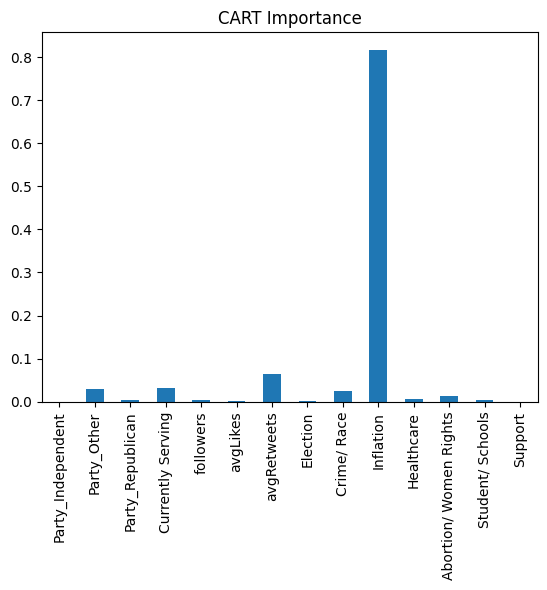

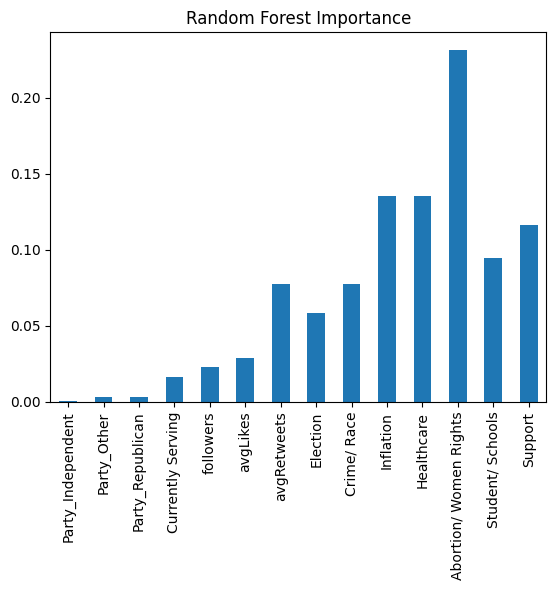

In [424]:
df = read("Features_Flair.xlsx")
linear(df)
lasso(df)
ridge(df)
cart(df)
forest(df)
bagging(df)
boosting(df)

# Bert

Linear Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
KellyForAlaska,0,0,1,Alaska,Kelly Tshibaka,0,-0.3349,-0.2922,-0.2140,-1.1961,...,-0.7188,-0.5299,-0.1970,-0.7948,Train,1.0000,44.2200,94138.0000,41.5674,0
lisamurkowski,0,0,1,Alaska,Lisa Murkowski,1,0.1147,-0.3786,-0.4585,-1.2430,...,-0.0783,-0.3294,-0.2130,-0.9390,Train,0.0000,42.8400,91205.0000,60.2721,1
RandPaul,0,0,1,Kentucky,Rand Paul,1,5.5396,1.0482,0.9810,-70.1619,...,-24.8829,-12.6799,-1.5013,-50.2127,Train,1.0000,61.7900,911587.0000,60.0745,0
SenCortezMasto,0,0,0,Nevada,Cathereine Cortez Masto,1,-0.2712,-0.2696,-0.2278,-3.3212,...,-0.4805,-1.5922,-0.2665,-1.8981,Train,0.0000,48.4300,458696.0000,54.1413,1
TedBuddNC,0,0,1,North Carolina,Ted Budd,0,-0.3615,-0.3445,-0.3902,-7.9413,...,-0.4937,-1.0917,-0.3486,-2.2833,Train,1.0000,50.7500,1891363.0000,43.7564,0
RepTimRyan,0,0,0,Ohio,Tim Ryan,0,-0.1506,-0.1791,-0.2543,-5.9141,...,-1.0151,-0.8369,-0.2848,-1.7536,Train,0.0000,46.7200,1883223.0000,31.6388,1
GeraldMalloyVT,0,0,1,Vermont,Gerald Malloy,0,-0.3736,-0.3951,-0.4735,-0.1632,...,-0.0296,-0.0327,-0.0126,-0.0546,Train,0.0000,28.1400,80237.0000,38.2641,1
WelchForVT,0,0,0,Vermont,Peter Welch,0,-0.3679,-0.3706,-0.4601,-1.3227,...,-0.1704,-0.3563,-0.0647,-0.2214,Train,1.0000,68.5400,195421.0000,31.5179,0
SmileyForWA,0,0,1,Washington,Tiffany Smiley,0,-0.3448,-0.1075,-0.0947,-9.2637,...,-2.4558,-1.6723,-0.5212,-6.0493,Train,0.0000,43.2600,1083026.0000,43.9205,1


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
Booker4KY,0,0,0,Kentucky,Charles Booker,0,0.2879,4.0453,4.6427,-23.0915,...,-1.6578,-9.2768,-0.2429,-12.3856,Test,0.0000,38.2100,563676.0000,61.8214,1
AdamLaxalt,0,0,1,Nevada,Adam Laxalt,0,-0.2855,-0.2270,-0.1759,-6.7826,...,-0.2475,-0.5233,-0.4980,-2.1590,Test,1.0000,48.5100,459494.0000,44.2481,0
CheriBeasleyNC,0,0,0,North Carolina,Cheri Beasley,0,-0.2830,1.0017,1.5394,-4.9978,...,-0.6953,-1.3407,-0.4818,-1.3772,Test,0.0000,47.1100,1755743.0000,51.6219,1
JDVance1,0,0,1,Ohio,J.D Vance,0,0.0247,0.2381,0.3194,-46.6475,...,-3.7548,-9.5388,-2.2850,-21.4935,Test,1.0000,53.2800,2147898.0000,28.1120,0
PattyMurray,0,0,0,Washington,Patty Murray,1,0.3473,0.0117,0.0334,-22.9980,...,-2.9779,-26.1321,-2.0757,-18.6237,Test,1.0000,56.7400,1420767.0000,35.3339,0


Lasso Results!


C:\Users\Arushi Jain\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.449e+02, tolerance: 3.651e+00
  model = cd_fast.enet_coordinate_descent(


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
KellyForAlaska,0,0,1,Alaska,Kelly Tshibaka,0,-0.3349,-0.2922,-0.2140,-1.1961,...,-0.7188,-0.5299,-0.1970,-0.7948,Train,1.0000,44.2200,94138.0000,40.5191,0
lisamurkowski,0,0,1,Alaska,Lisa Murkowski,1,0.1147,-0.3786,-0.4585,-1.2430,...,-0.0783,-0.3294,-0.2130,-0.9390,Train,0.0000,42.8400,91205.0000,59.3582,1
RandPaul,0,0,1,Kentucky,Rand Paul,1,5.5396,1.0482,0.9810,-70.1619,...,-24.8829,-12.6799,-1.5013,-50.2127,Train,1.0000,61.7900,911587.0000,62.0855,0
SenCortezMasto,0,0,0,Nevada,Cathereine Cortez Masto,1,-0.2712,-0.2696,-0.2278,-3.3212,...,-0.4805,-1.5922,-0.2665,-1.8981,Train,0.0000,48.4300,458696.0000,53.8892,1
TedBuddNC,0,0,1,North Carolina,Ted Budd,0,-0.3615,-0.3445,-0.3902,-7.9413,...,-0.4937,-1.0917,-0.3486,-2.2833,Train,1.0000,50.7500,1891363.0000,44.6768,0
GeraldMalloyVT,0,0,1,Vermont,Gerald Malloy,0,-0.3736,-0.3951,-0.4735,-0.1632,...,-0.0296,-0.0327,-0.0126,-0.0546,Train,0.0000,28.1400,80237.0000,38.3285,1
WelchForVT,0,0,0,Vermont,Peter Welch,0,-0.3679,-0.3706,-0.4601,-1.3227,...,-0.1704,-0.3563,-0.0647,-0.2214,Train,1.0000,68.5400,195421.0000,32.8175,0
TheOtherMandela,0,0,0,Wisconsin,Mandela Barnes,0,-0.1574,0.9767,1.9697,-15.9246,...,-3.8877,-5.7502,-1.0479,-9.1490,Train,0.0000,49.5000,1310416.0000,46.1384,1


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
Booker4KY,0,0,0,Kentucky,Charles Booker,0,0.2879,4.0453,4.6427,-23.0915,...,-1.6578,-9.2768,-0.2429,-12.3856,Test,0.0000,38.2100,563676.0000,65.9050,1
AdamLaxalt,0,0,1,Nevada,Adam Laxalt,0,-0.2855,-0.2270,-0.1759,-6.7826,...,-0.2475,-0.5233,-0.4980,-2.1590,Test,1.0000,48.5100,459494.0000,43.0447,0
CheriBeasleyNC,0,0,0,North Carolina,Cheri Beasley,0,-0.2830,1.0017,1.5394,-4.9978,...,-0.6953,-1.3407,-0.4818,-1.3772,Test,0.0000,47.1100,1755743.0000,48.4172,1
SenRonJohnson,0,0,1,Wisconsin,Ronald Harold Johnson,1,0.2052,2.0412,3.3380,-141.9782,...,-20.2467,-11.0470,0.0000,-36.8975,Test,1.0000,50.5000,1336870.0000,39.6892,0


Ridge Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
KellyForAlaska,0,0,1,Alaska,Kelly Tshibaka,0,-0.3349,-0.2922,-0.2140,-1.1961,...,-0.7188,-0.5299,-0.1970,-0.7948,Train,1.0000,44.2200,94138.0000,41.0158,0
lisamurkowski,0,0,1,Alaska,Lisa Murkowski,1,0.1147,-0.3786,-0.4585,-1.2430,...,-0.0783,-0.3294,-0.2130,-0.9390,Train,0.0000,42.8400,91205.0000,59.7634,1
RandPaul,0,0,1,Kentucky,Rand Paul,1,5.5396,1.0482,0.9810,-70.1619,...,-24.8829,-12.6799,-1.5013,-50.2127,Train,1.0000,61.7900,911587.0000,61.2339,0
SenCortezMasto,0,0,0,Nevada,Cathereine Cortez Masto,1,-0.2712,-0.2696,-0.2278,-3.3212,...,-0.4805,-1.5922,-0.2665,-1.8981,Train,0.0000,48.4300,458696.0000,52.9037,1
TedBuddNC,0,0,1,North Carolina,Ted Budd,0,-0.3615,-0.3445,-0.3902,-7.9413,...,-0.4937,-1.0917,-0.3486,-2.2833,Train,1.0000,50.7500,1891363.0000,44.4481,0
RepTimRyan,0,0,0,Ohio,Tim Ryan,0,-0.1506,-0.1791,-0.2543,-5.9141,...,-1.0151,-0.8369,-0.2848,-1.7536,Train,0.0000,46.7200,1883223.0000,30.6316,1
GeraldMalloyVT,0,0,1,Vermont,Gerald Malloy,0,-0.3736,-0.3951,-0.4735,-0.1632,...,-0.0296,-0.0327,-0.0126,-0.0546,Train,0.0000,28.1400,80237.0000,38.2370,1
WelchForVT,0,0,0,Vermont,Peter Welch,0,-0.3679,-0.3706,-0.4601,-1.3227,...,-0.1704,-0.3563,-0.0647,-0.2214,Train,1.0000,68.5400,195421.0000,31.1368,0
SmileyForWA,0,0,1,Washington,Tiffany Smiley,0,-0.3448,-0.1075,-0.0947,-9.2637,...,-2.4558,-1.6723,-0.5212,-6.0493,Train,0.0000,43.2600,1083026.0000,43.6002,1


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
Booker4KY,0,0,0,Kentucky,Charles Booker,0,0.2879,4.0453,4.6427,-23.0915,...,-1.6578,-9.2768,-0.2429,-12.3856,Test,0.0000,38.2100,563676.0000,64.6324,1
AdamLaxalt,0,0,1,Nevada,Adam Laxalt,0,-0.2855,-0.2270,-0.1759,-6.7826,...,-0.2475,-0.5233,-0.4980,-2.1590,Test,1.0000,48.5100,459494.0000,43.5404,0
CheriBeasleyNC,0,0,0,North Carolina,Cheri Beasley,0,-0.2830,1.0017,1.5394,-4.9978,...,-0.6953,-1.3407,-0.4818,-1.3772,Test,0.0000,47.1100,1755743.0000,49.1487,1
JDVance1,0,0,1,Ohio,J.D Vance,0,0.0247,0.2381,0.3194,-46.6475,...,-3.7548,-9.5388,-2.2850,-21.4935,Test,1.0000,53.2800,2147898.0000,30.3585,0
PattyMurray,0,0,0,Washington,Patty Murray,1,0.3473,0.0117,0.0334,-22.9980,...,-2.9779,-26.1321,-2.0757,-18.6237,Test,1.0000,56.7400,1420767.0000,43.1299,0
SenRonJohnson,0,0,1,Wisconsin,Ronald Harold Johnson,1,0.2052,2.0412,3.3380,-141.9782,...,-20.2467,-11.0470,0.0000,-36.8975,Test,1.0000,50.5000,1336870.0000,45.3697,0


CART Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
willboydforAL,0,0,0,Alabama,Will Boyd,0,4283,37.1389,11.3056,0.1353,...,0.0018,0.0192,0.0091,0.0994,Train,0.0000,30.9200,435431.0000,30.9200,1
SenMarkKelly,0,0,0,Arizona,Mark Kelly,1,136417,549.5000,145.6667,-15.8128,...,-4.5826,-6.6507,-0.2789,-9.8275,Train,1.0000,51.7500,1060031.0000,51.7500,0
SenCortezMasto,0,0,0,Nevada,Cathereine Cortez Masto,1,70551,180.2479,66.0579,-3.3212,...,-0.4805,-1.5922,-0.2665,-1.8981,Train,0.0000,48.4300,458696.0000,48.4300,1


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
KatieBrittforAL,0,0,1,Alabama,Katie Britt,0,15632,44.0390,6.6818,-0.9904,...,-0.0443,-0.2030,-0.0427,-0.3463,Test,1.0000,66.7500,940054.0000,28.7400,0
bgmasters,0,0,1,Arizona,Blake Masters,0,175270,1099.6527,273.1976,-27.0448,...,-1.1060,-7.1134,-2.9701,-8.8721,Test,0.0000,46.1300,944958.0000,55.4700,1
AdamLaxalt,0,0,1,Nevada,Adam Laxalt,0,60766,236.1633,79.1122,-6.7826,...,-0.2475,-0.5233,-0.4980,-2.1590,Test,1.0000,48.5100,459494.0000,43.2600,0


Forest Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
KellyForAlaska,0,0,1,Alaska,Kelly Tshibaka,0,27036,150.7143,69.5238,-1.1961,...,-0.7188,-0.5299,-0.1970,-0.7948,Train,1.0000,44.2200,94138.0000,42.8366,0
lisamurkowski,0,0,1,Alaska,Lisa Murkowski,1,334102,37.4182,8.1182,-1.2430,...,-0.0783,-0.3294,-0.2130,-0.9390,Train,0.0000,42.8400,91205.0000,48.9068,1
SenCortezMasto,0,0,0,Nevada,Cathereine Cortez Masto,1,70551,180.2479,66.0579,-3.3212,...,-0.4805,-1.5922,-0.2665,-1.8981,Train,0.0000,48.4300,458696.0000,51.1111,1
DrOz,0,0,1,Pennsylvania,Mehmet Oz,0,3875217,1016.5000,296.0300,-168.5005,...,-11.4039,-20.6627,-8.9592,-40.3642,Train,0.0000,46.6200,2469945.0000,49.9947,1
JohnFetterman,0,0,0,Pennsylvania,John Fetterman,0,839420,8639.3150,1354.2700,-107.2970,...,-10.8436,-25.7771,-5.3026,-29.0492,Train,1.0000,50.9700,2700885.0000,49.8137,0


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
AdamLaxalt,0,0,1,Nevada,Adam Laxalt,0,60766,236.1633,79.1122,-6.7826,...,-0.2475,-0.5233,-0.4980,-2.1590,Test,1.0000,48.5100,459494.0000,47.3807,0


Bagging Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
KellyForAlaska,0,0,1,Alaska,Kelly Tshibaka,0,27036,150.7143,69.5238,-1.1961,...,-0.7188,-0.5299,-0.1970,-0.7948,Train,1.0000,44.2200,94138.0000,40.1873,0
lisamurkowski,0,0,1,Alaska,Lisa Murkowski,1,334102,37.4182,8.1182,-1.2430,...,-0.0783,-0.3294,-0.2130,-0.9390,Train,0.0000,42.8400,91205.0000,40.4061,1
SenMarkKelly,0,0,0,Arizona,Mark Kelly,1,136417,549.5000,145.6667,-15.8128,...,-4.5826,-6.6507,-0.2789,-9.8275,Train,1.0000,51.7500,1060031.0000,40.7307,0
RepValDemings,0,0,0,Florida,Val Demings,0,460893,1411.1300,426.9050,-8.8607,...,-1.9770,-4.6974,-1.1813,-10.7758,Train,0.0000,41.2600,3198259.0000,41.5931,1
SenRubioPress,0,0,1,Florida,Marco Rubio,1,149081,25.8881,9.8284,-1.2934,...,-0.2283,-0.3370,-0.2216,-1.2675,Train,1.0000,57.6900,4471728.0000,40.1899,0
HerschelWalker,0,0,1,Georgia,Herschel Walker,0,756537,6363.3684,944.4737,-280.7316,...,-3.1485,-96.1765,-28.9056,-248.0347,Train,0.0000,48.5200,1906267.0000,41.7388,1
Eric_Schmitt,0,0,1,Missouri,Eric Schmitt,0,57495,318.6667,75.4298,-19.5658,...,-3.3386,-4.4010,-2.6794,-9.2014,Train,1.0000,55.4700,1143636.0000,40.4853,0
TedBuddNC,0,0,1,North Carolina,Ted Budd,0,8892,82.0885,25.2743,-7.9413,...,-0.4937,-1.0917,-0.3486,-2.2833,Train,1.0000,50.7500,1891363.0000,40.1586,0
SenatorLankford,0,0,1,Oklahoma,James Lankford,1,119622,36.9189,8.9189,-11.7916,...,-1.1781,-1.0053,-0.8615,-4.9690,Train,1.0000,64.3000,739298.0000,40.2248,0


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
bgmasters,0,0,1,Arizona,Blake Masters,0,175270,1099.6527,273.1976,-27.0448,...,-1.1060,-7.1134,-2.9701,-8.8721,Test,0.0000,46.1300,944958.0000,41.2613,1
SenatorWarnock,0,0,0,Georgia,Raphael Warnock,1,169134,496.4121,132.9636,-3.5293,...,-1.1322,-1.0215,-0.2675,-2.3702,Test,1.0000,49.4200,1941515.0000,40.6173,0
buschvalentine,0,0,0,Missouri,Trudy Busch Valentine,0,17832,569.5682,210.0341,-2.2995,...,-0.3286,-1.2529,-0.3250,-1.0721,Test,0.0000,42.1400,868875.0000,40.5787,1
CheriBeasleyNC,0,0,0,North Carolina,Cheri Beasley,0,62507,1846.3750,509.9010,-4.9978,...,-0.6953,-1.3407,-0.4818,-1.3772,Test,0.0000,47.1100,1755743.0000,41.1175,1
madisonhornok,0,0,0,Oklahoma,Madison Horn,0,20052,434.6397,132.1103,-2.4716,...,-0.2216,-0.5988,-0.2135,-0.7605,Test,0.0000,32.1000,368979.0000,40.4113,1
SenMikeLee,0,0,1,Utah,Mike Lee,1,643901,161.4000,40.0000,-37.7026,...,-2.7802,-3.3568,-1.9392,-14.1046,Test,1.0000,54.6700,496230.0000,40.9812,0


Boosting Results!


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
KellyForAlaska,0,0,1,Alaska,Kelly Tshibaka,0,27036,150.7143,69.5238,-1.1961,...,-0.7188,-0.5299,-0.1970,-0.7948,Train,1.0000,44.2200,94138.0000,43.5982,0
lisamurkowski,0,0,1,Alaska,Lisa Murkowski,1,334102,37.4182,8.1182,-1.2430,...,-0.0783,-0.3294,-0.2130,-0.9390,Train,0.0000,42.8400,91205.0000,48.1450,1
SenCortezMasto,0,0,0,Nevada,Cathereine Cortez Masto,1,70551,180.2479,66.0579,-3.3212,...,-0.4805,-1.5922,-0.2665,-1.8981,Train,0.0000,48.4300,458696.0000,55.3367,1
DrOz,0,0,1,Pennsylvania,Mehmet Oz,0,3875217,1016.5000,296.0300,-168.5005,...,-11.4039,-20.6627,-8.9592,-40.3642,Train,0.0000,46.6200,2469945.0000,48.8800,1
JohnFetterman,0,0,0,Pennsylvania,John Fetterman,0,839420,8639.3150,1354.2700,-107.2970,...,-10.8436,-25.7771,-5.3026,-29.0492,Train,1.0000,50.9700,2700885.0000,44.7706,0


,Party_Independent,Party_Other,Party_Republican,State,Candidate,Currently Serving,followers,avgLikes,avgRetweets,Election,...,Healthcare,Abortion/ Women Rights,Student/ Schools,Support,Train/Test,Elected,Vote Share,Votes,predictions,predictedWinner
Twitter ID,,,,,,,,,,,,,,,,,,,,,
AdamLaxalt,0,0,1,Nevada,Adam Laxalt,0,60766,236.1633,79.1122,-6.7826,...,-0.2475,-0.5233,-0.4980,-2.1590,Test,1.0000,48.5100,459494.0000,48.8800,0


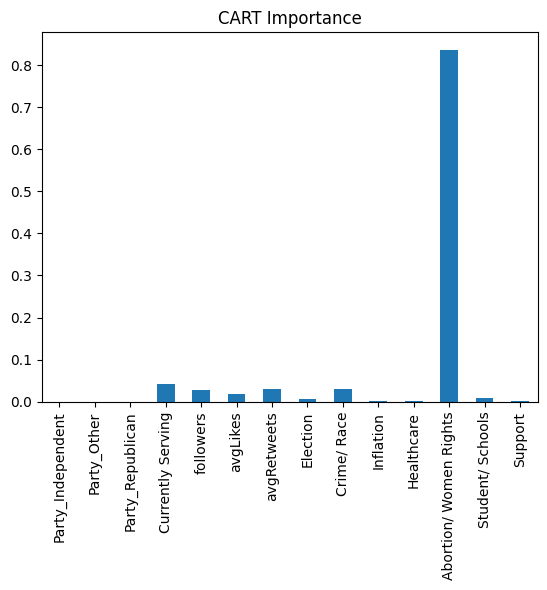

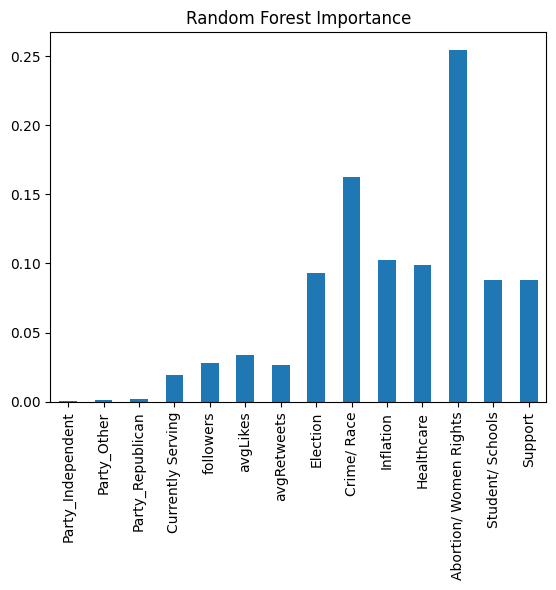

In [423]:
df = read("Features_Bert.xlsx")
linear(df)
lasso(df)
ridge(df)
cart(df)
forest(df)
bagging(df)
boosting(df)